# Transitioning to autonomous driving: <br>Mixed vehicle autonomy levels on freeways
### Notebook to analyse simulation warm-up time.

Jesse Poland<br>
TU Delft<br>
Date: 02-10-2024<br>

### 0. Python packages and loading data files

First, Python packages are imported to provide specific functionalities within the notebook. Then, the file paths are set to retrieve stored simulation data for all experiment runs and seeds. The simulation data is loaded into Pandas DataFrames, making the data ready for analysis.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu
from IPython.display import display
import zipfile

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

pd.set_option('display.max_rows', None)

In [2]:
# simulation output folder
experiment_name = 'explore_demand_test'

# load Java simulation data
# experiment_folder = fr'F:\jesse_sim_results\{experiment_name}'
experiment_folder = fr'..\data\{experiment_name}'

# available files
input_values = 'inputValues.csv'
intermediate_output = 'intermediateOutputData.csv'
single_output = 'singleOutputData.csv'
sequence_output = 'sequenceOutputData.csv'
lane_change_output = 'laneChangeOutputData.csv'
collision_output = 'collisionOutputData.csv'

In [3]:
# function to get a list of all file/folder names within a folder
def get_file_names(path):
    return os.listdir(path)

# load available seed folders
seed_folders = get_file_names(experiment_folder)

In [4]:
# function to retrieve any data within the project folder as dataframe
def load_dataframe(columns_of_interest, folder, file, input_file=None):
    # create empty DataFrame
    df = pd.DataFrame()
    
    # loop through all seed folders from this experiment
    for seed_name in get_file_names(folder):
        # get all runs within this experiment
        run_folders = get_file_names(os.path.join(folder, seed_name))

        # go through all runs
        for run_folder in run_folders:
            run_number = int(run_folder.split('_')[1])
            data_folder = os.path.join(folder, seed_name, run_folder)

            # open zip file (remove .csv form file name)
            try:
                with zipfile.ZipFile(os.path.join(data_folder, fr'{file[:-4]}.zip'), 'r') as zip_ref:
                    # read sequence csv
                    with zip_ref.open(file) as data_file:
                        df_run = pd.read_csv(data_file)
                        df_interest = df_run[columns_of_interest].copy()
                        df_interest['run'] = run_number
                # add input values to the dataframe if the input file is specified
                if input_file is not None:
                    # open input zip file
                    with zipfile.ZipFile(os.path.join(data_folder, fr'{input_file[:-4]}.zip'), 'r') as zip_ref:
                        # read input csv
                        with zip_ref.open(input_file) as input_data_file:
                            df_input = pd.read_csv(input_data_file)
                    # broadcast input data to all rows in df_interest
                    for col in df_input.columns:
                        df_interest[col] = df_input[col].iloc[0]
    
                # add this data to the main DataFrame
                df = pd.concat([df, df_interest])
            except:
                print(f'An error occured when trying to read data from: {data_folder}. This folder may contain a BadZipFile or is empty.')
    
    # return resulting DataFrame
    df.reset_index(drop=True, inplace=True)
    return df
    

In [5]:
# get GTU data
variables = ['time', 'gtu_id', 'gtu_type', 'reaction_time']
df_gtu = load_dataframe(variables, experiment_folder, sequence_output, input_values)
# only include sensitivity analysis parameter from input data
# df_gtu = df_gtu[variables + ['seed', 'run', 'sensitivity_analysis_value']]
df_gtu = df_gtu[variables + ['seed', 'run', 'main_demand']]
# rename column of the sensitivity analysis parameter
# df_gtu.rename(columns = {'sensitivity_analysis_value':'rt_max'}, inplace = True)

In [24]:
# only include drivers with deteriorated reaction time
df_rt = df_gtu[df_gtu['reaction_time'] > 0]

In [27]:
def sensitivity_analysis_line_plot_mean(df, sens_param, dependent_param):
    # remove NaN and inf values in time headway since not all data points have a leading vehicle
    df = df.replace([np.inf, -np.inf], np.nan)
    df = df.dropna(subset=[dependent_param])
    
    # group by the sensitivity parameter and calculate mean, min, and max of the dependent parameter
    stats_by_sens_param = df.groupby(sens_param)[dependent_param].agg(['mean', 'min', 'max']).reset_index()
    stats_by_sens_param.rename(columns={'mean': f'mean_{dependent_param}', 'min': f'min_{dependent_param}', 'max': f'max_{dependent_param}'}, inplace=True)
    
    # sort values by the sensitivity parameter to ensure correct plotting order
    stats_by_sens_param = stats_by_sens_param.sort_values(by=sens_param)
    
    # plot the mean, min, and max values against the sensitivity analysis parameter
    plt.figure(figsize=(10, 6))
    plt.plot(stats_by_sens_param[sens_param], stats_by_sens_param[f'mean_{dependent_param}'], marker='o', color='blue', label='Mean')
    # plt.fill_between(stats_by_sens_param[sens_param], 
    #                  stats_by_sens_param[f'min_{dependent_param}'], 
    #                  stats_by_sens_param[f'max_{dependent_param}'], 
    #                  color='lightblue', alpha=0.3, label='Range (Min to Max)')

    # display data point values
    for i, row in stats_by_sens_param.iterrows():
        plt.text(row[sens_param], row[f'mean_{dependent_param}'], f'({row[sens_param]:.2f}, {row[f"mean_{dependent_param}"]:.2f})', fontsize=9, ha='right')
    
    # labels and title
    plt.xlabel(f'Sensitivity parameter ({sens_param})')
    plt.ylabel(f'{dependent_param.replace("_", " ")} [s]')
    plt.title(f'Influence of {sens_param.replace("_", " ")} on {dependent_param.replace("_", " ")}')
    plt.grid(True)
    plt.legend()
    plt.show()


def sensitivity_analysis_line_plot_mode(df, sens_param, dependent_param):
    # remove NaN and inf values in time headway since not all data points have a leading vehicle
    df = df.replace([np.inf, -np.inf], np.nan)
    df = df.dropna(subset=[dependent_param])
    
    # calculate mode
    mode_by_sens_param = df.groupby(sens_param)[dependent_param].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)
    
    # sort values by the sensitivity parameter to ensure correct plotting order
    mode_by_sens_param = mode_by_sens_param.sort_index()
    
    # plot the mode values against the sensitivity analysis parameter
    plt.figure(figsize=(10, 6))
    plt.plot(mode_by_sens_param.index, mode_by_sens_param.values, marker='o', color='black', label='Mode')
    # plt.fill_between(stats_by_sens_param[sens_param], 
    #                  stats_by_sens_param[f'min_{dependent_param}'], 
    #                  stats_by_sens_param[f'max_{dependent_param}'], 
    #                  color='lightblue', alpha=0.3, label='Range (Min to Max)')

    # display data point values
    for sens_value, mode_value in mode_by_sens_param.items():
        plt.text(sens_value, mode_value, f'({sens_value:.2f}, {mode_value:.2f})', fontsize=9, ha='right', color='black')
    
    # labels and title
    plt.xlabel(f'Sensitivity parameter ({sens_param})')
    plt.ylabel(f'{dependent_param.replace("_", " ")} [s]')
    plt.title(f'Influence of {sens_param.replace("_", " ")} on {dependent_param.replace("_", " ")}')
    plt.grid(True)
    plt.legend()
    plt.show()

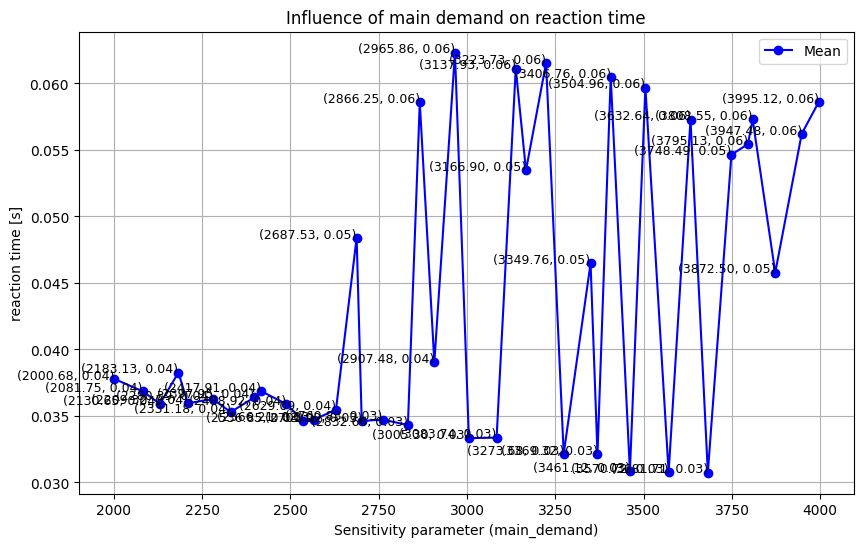

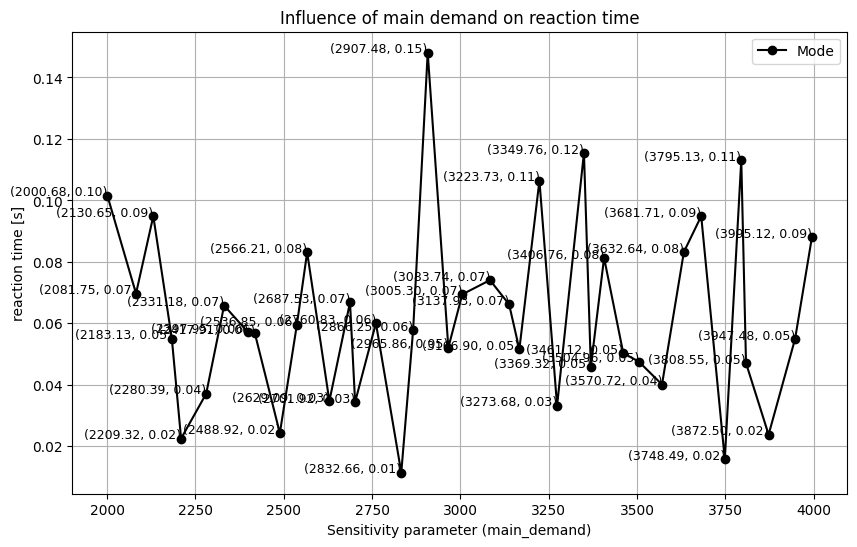

In [28]:
# show influence of t_max on headway_time
sensitivity_analysis_line_plot_mean(df_rt, 'main_demand', 'reaction_time')
sensitivity_analysis_line_plot_mode(df_rt, 'main_demand', 'reaction_time')

### Conclusion
